In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport solvers

In [2]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import sys

# Data Description and Experiment Setup

We first load the chinese stock data. The data includes `832` stocks traded in the Shanghai Stock Exchange and `775` stocks traded in the Shenzhen Stock exchange. The stocks included in the dataset must be on the list before 2010 (so that it has at least 10 years of trading history). 

Here's some basic information about the dataset we have:

* For each stock the data is saved in pd.dataframe
* We have daily sampled data from 2010-2019 (10 years), the data has around 2400 rows in total (~240 trading days per year).
* Explanation of each column in the data table:
    + **ts_code**: ticker of the stock,
    + **open**: open price for each day,
    + **high**: max price of each day,
    + **low**: min price of each day,
    + **close**: close price of each day,
    + **pre_close**: close price of the previous trading day,
    + **change**: close - pre_close,
    + **pct_chg**: (close - pre_close) / pre_close,
    + **vol**: trading share volume in each day (unit: 100 shares),
    + **amount**: trading RMB volume in each day (unit: 1000 RMB),
    + **turnover_rate**: percentage turnover rate,
    + **volume_ratio**: also called Upside/Downside Ratio, It's calculated by dividing total volume on days a stock's price ended higher by the total volume on days when it closed lower. The ratio should generally be above 1.0 in a stock that is about to break out.
    + **pe**: The price-earnings ratio, also known as P/E ratio, P/E, or PER, is the ratio of a company's share price to the company's earnings per share. The ratio is used for valuing companies and to find out whether they are overvalued or undervalued. 
    + **pb**: The P/B ratio compares a company's market capitalization, or market value, to its book value. Specifically, it compares the company's stock price to its book value per share (BVPS). The market capitalization (company's value) is its share price multiplied by the number of outstanding shares.
    + **dv_ratio**: The dividend yield or dividend-price ratio of a share is the dividend per share, divided by the price per share.
    + **total_mv**: total market cap (unit 10000 RMB)

In [3]:
SZ_code_list = pd.read_pickle('./SZ_code_list.pkl')
SH_code_list = pd.read_pickle('./SH_code_list.pkl')
trading_dates = pd.read_pickle('./trading_dates.pkl')
total_code_list = pd.concat([SZ_code_list, SH_code_list])
total_stock_num = len(total_code_list)
sample_stock_num = 50

Our experiment proceeds as follows. The full experiment consists of multiple tests. In each test we random sample ``50`` stocks as the stock pool and try to construct the portfolio using these ``50`` stocks. The goal of this experiement is to propose a **daily rebalanced trading strategy**.

**Description of the training and testing procedure**:
* The strategy is trained and tested in rolling fashion.
* For the moment we employ a two-year rolling training window with uniform weight. 
* The first rolling training window includes all the data in 2010-2011.
* We start to test the performance of the strategy from the begining of 2012.
* The training and testing is repeated daily in 2012-2016 (5 years). 
* The data in 2017-2019 (3 years is saved for further use in order to avoid over-fitting).

# Mean Variance Optimization Without Constraint

First we consider a mean-variance optimization model without any capital or long-short constraint. The optimization problem is given by:
$$
\min_{\theta} \theta^\top\rm{Cov}(R)\theta - \lambda \theta^\top\rm{E}(R)
$$
where the covariance matrix $\rm{Cov}(R)$ and return vector $\rm{E}(R)$ is calibrated using the 2 years historical data.
Suppose that we don't have any constraint for $\theta$, then the first order optimality condition implies an closed form optimal solution:
$$
\theta^{\ast} = (1/2) \lambda \cdot\rm{inv}(\rm{Cov}(R))\cdot \rm{E}(R)
$$
We first take a look at the optimal solution in a single test.

In [4]:
PnL_table = utils.backtest.resample_experiments(exp_num=50, 
                                                sample_stock_num=20, 
                                                solver=solvers.meanvariance.mean_variance_long_only_opt_mosek_kernel,
                                                solver_name_prefix='vanilla_',
                                                reg_params=5)

In [413]:
ts_code_generator = np.random.RandomState(42)
sampled_ts_codes = ts_code_generator.choice(total_code_list, size = sample_stock_num, replace = False)
info_list = ['pct_chg']
portfolio = {col_name:pd.DataFrame(index = trading_dates) for col_name in info_list}
for ts_code in sampled_ts_codes:
    table = utils.datareader.load_joint_table(ts_code)
    for info_name in info_list:
        portfolio[info_name][ts_code] = table[info_name]
for info_name in info_list:
    portfolio[info_name].fillna(0, inplace = True)
mean_nparray = portfolio['pct_chg'].rolling(window = '730d').mean().values
cov_nparray = portfolio['pct_chg'].rolling(window = '730d').cov().values

Take a look at the correlation between historical return and the leading return:
$$Corr(E(R|F_t), R_{t+1})$$
We plot the histogram of the correlation among 50 sampled stocks:

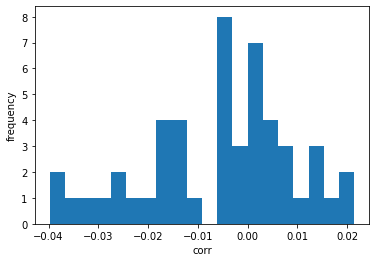

In [417]:
forward_corr = np.mean(portfolio['pct_chg'].shift(-1)*portfolio['pct_chg'].rolling(window = '730d').mean()) \
/ np.sqrt(np.mean(portfolio['pct_chg'].shift(-1)**2) * np.mean(portfolio['pct_chg'].rolling(window = '730d').mean()**2))
plt.hist(forward_corr, bins = 20)
plt.xlabel('corr');plt.ylabel('frequency');plt.show()

Above test indicates $E(R|F_t)$ don't have clear predictive power on $R_{t+1}$. Now we start to use the mean-variance model to construct portfolio.

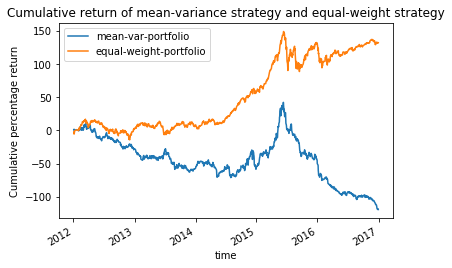

In [423]:
theta_nparray = solvers.meanvariance.mean_variance_opt(training_ids, mean_nparray, cov_nparray, reg_params=10)
theta_df = pd.DataFrame(data=theta_nparray, 
                        columns=portfolio['pct_chg'].columns, 
                        index=portfolio['pct_chg'].index)
(theta_df * portfolio['pct_chg'].shift(-1)).sum(axis = 1)[training_ids].cumsum().plot()
portfolio['pct_chg'].mean(axis = 1)[training_ids].cumsum().plot()
plt.legend(['mean-var-portfolio','equal-weight-portfolio'])
plt.title('Cumulative return of mean-variance strategy and equal-weight strategy')
plt.ylabel('Cumulative percentage return')
plt.show()

We resample the stock pool for `exp_num=50` times, and use the resampled stock pool to conduct `50` mean-variance test. In each test we compute the Sharpe ratio of two different strategies:

In [443]:
exp_num = 50
ts_code_generator = np.random.RandomState(42)
mean_var_sharpe_list = []
uniform_sharpe_list = []
info_list = ['pct_chg']
for exp in tqdm.tqdm(range(exp_num)):
    portfolio = utils.preprocess.gen_portfolio_data_table(ts_code_generator, info_list, sample_stock_num)
    mean_nparray = portfolio['pct_chg'].rolling(window = '730d').mean().values
    cov_nparray = portfolio['pct_chg'].rolling(window = '730d').cov().values
    training_ids = np.where((portfolio['pct_chg'].index >= '2012') & (portfolio['pct_chg'].index < '2017'))[0]
    theta_nparray = solvers.meanvariance.mean_variance_opt(training_ids, mean_nparray, cov_nparray, reg_params=0.5)
    theta_df = pd.DataFrame(data=theta_nparray, 
                            columns=portfolio['pct_chg'].columns, 
                            index=portfolio['pct_chg'].index)
    mean_var_PnL = (theta_df * portfolio['pct_chg'].shift(-1)).sum(axis = 1)[training_ids]
    uniform_PnL = portfolio['pct_chg'].mean(axis = 1)[training_ids]
    mean_var_Sharpe = np.sqrt(252)*mean_var_PnL.mean()/mean_var_PnL.std()
    uniform_Sharpe = np.sqrt(252)*uniform_PnL.mean()/uniform_PnL.std()
    mean_var_sharpe_list.append(mean_var_Sharpe)
    uniform_sharpe_list.append(uniform_Sharpe)

100%|██████████| 50/50 [04:05<00:00,  4.90s/it]


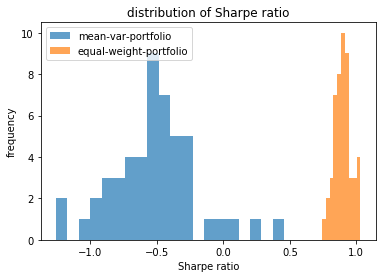

Mean Sharpe ratio is: 
mean-var-portfolio = -0.52,	equal-weight-portfolio=0.90


In [444]:
plt.hist(mean_var_sharpe_list, alpha=0.7, bins = 20)
plt.hist(uniform_sharpe_list, alpha=0.7, bins = 10)
plt.legend(['mean-var-portfolio','equal-weight-portfolio'])
plt.xlabel('Sharpe ratio')
plt.ylabel('frequency')
plt.title('distribution of Sharpe ratio')
plt.show()
print('Mean Sharpe ratio is: \nmean-var-portfolio = {:.2f},\tequal-weight-portfolio={:.2f}'.
      format(np.mean(mean_var_sharpe_list), np.mean(uniform_sharpe_list)))

# Mean Variance Optimization With Constraint

Due to strong regulations, it is generally hard to short stocks in the chinese market. We consider a mean-variance optimization model with capital or long-short constraint. The optimization problem is given by:
$$
\min_{\theta} \theta^\top\rm{Cov}(R)\theta - \lambda \theta^\top\rm{E}(R), \quad\rm{s.t.}\quad\theta_i \geq 0, \sum\theta_i\leq 1.
$$
No explicit solution is available for this optimization problem, and we will solve this problem using the Mosek qudratic optization API.

In [425]:
ts_code_generator = np.random.RandomState(42)
sampled_ts_codes = ts_code_generator.choice(total_code_list, size = sample_stock_num, replace = False)
info_list = ['pct_chg']
portfolio = {col_name:pd.DataFrame(index = trading_dates) for col_name in info_list}
for ts_code in sampled_ts_codes:
    table = utils.datareader.load_joint_table(ts_code)
    for info_name in info_list:
        portfolio[info_name][ts_code] = table[info_name]
for info_name in info_list:
    portfolio[info_name].fillna(0, inplace = True)
mean_nparray = portfolio['pct_chg'].rolling(window = '730d').mean().values
cov_nparray = portfolio['pct_chg'].rolling(window = '730d').cov().values
training_ids = np.where((portfolio['pct_chg'].index >= '2012') & (portfolio['pct_chg'].index < '2017'))[0]

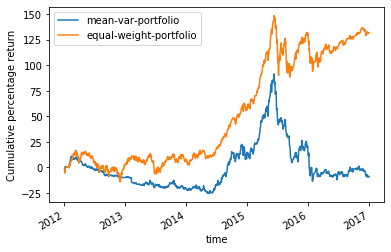

In [426]:
theta_nparray = solvers.meanvariance.mean_variance_long_only_opt(training_ids, mean_nparray, cov_nparray, reg_params=10)
theta_df = pd.DataFrame(data=theta_nparray, 
                        columns=portfolio['pct_chg'].columns, 
                        index=portfolio['pct_chg'].index)
(theta_df * portfolio['pct_chg'].shift(-1)).sum(axis = 1)[training_ids].cumsum().plot()
portfolio['pct_chg'].mean(axis = 1)[training_ids].cumsum().plot()
plt.legend(['mean-var-portfolio','equal-weight-portfolio'])
plt.ylabel('Cumulative percentage return')
plt.show()

We resample the stock pool for `exp_num=50` times, and use the resampled stock pool to conduct `50` mean-variance test. In each test we compute the Sharpe ratio of two different strategies:

In [345]:
exp_num = 50
ts_code_generator = np.random.RandomState(42)
mean_var_sharpe_list = []
uniform_sharpe_list = []
info_list = ['pct_chg']
for exp in tqdm.tqdm(range(exp_num)):
    portfolio = utils.preprocess.gen_portfolio_data_table(ts_code_generator, info_list, sample_stock_num)
    mean_nparray = portfolio['pct_chg'].rolling(window = '730d').mean().values
    cov_nparray = portfolio['pct_chg'].rolling(window = '730d').cov().values
    training_ids = np.where((portfolio['pct_chg'].index >= '2012') & (portfolio['pct_chg'].index < '2017'))[0]
    theta_nparray = solvers.meanvariance.mean_variance_long_only_opt(training_ids, mean_nparray, cov_nparray, reg_params=0.5)
    theta_df = pd.DataFrame(data=theta_nparray, 
                            columns=portfolio['pct_chg'].columns, 
                            index=portfolio['pct_chg'].index)
    mean_var_PnL = (theta_df * portfolio['pct_chg'].shift(-1)).sum(axis = 1)[training_ids]
    uniform_PnL = portfolio['pct_chg'].mean(axis = 1)[training_ids]
    mean_var_Sharpe = np.sqrt(252)*mean_var_PnL.mean()/mean_var_PnL.std()
    uniform_Sharpe = np.sqrt(252)*uniform_PnL.mean()/uniform_PnL.std()
    mean_var_sharpe_list.append(mean_var_Sharpe)
    uniform_sharpe_list.append(uniform_Sharpe)

100%|██████████| 50/50 [17:30<00:00, 21.00s/it]


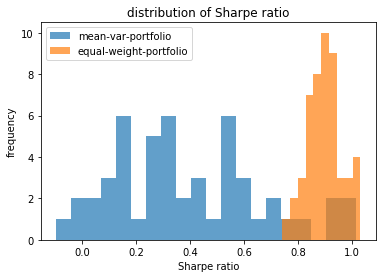

Mean Sharpe ratio is: 
mean-var-portfolio = 0.40,	equal-weight-portfolio=0.90


In [441]:
plt.hist(mean_var_sharpe_list, alpha=0.7, bins = 20)
plt.hist(uniform_sharpe_list, alpha=0.7, bins = 10)
plt.legend(['mean-var-portfolio','equal-weight-portfolio'])
plt.xlabel('Sharpe ratio')
plt.ylabel('frequency')
plt.title('distribution of Sharpe ratio')
plt.show()
print('Mean Sharpe ratio is: \nmean-var-portfolio = {:.2f},\tequal-weight-portfolio={:.2f}'.
      format(np.mean(mean_var_sharpe_list), np.mean(uniform_sharpe_list)))

# Mean Variance Optimization With Return Constraint

$$
\min_{\theta} \theta^\top\rm{Cov}(R)\theta, \quad\rm{s.t.}\quad\theta_i \geq 0,\; \sum\theta_i\leq 1, \;\theta^\top\rm{E}(R)\geq \alpha.
$$

In [446]:
ts_code_generator = np.random.RandomState(42)
sampled_ts_codes = ts_code_generator.choice(total_code_list, size = sample_stock_num, replace = False)
info_list = ['pct_chg']
portfolio = {col_name:pd.DataFrame(index = trading_dates) for col_name in info_list}
for ts_code in sampled_ts_codes:
    table = utils.datareader.load_joint_table(ts_code)
    for info_name in info_list:
        portfolio[info_name][ts_code] = table[info_name]
for info_name in info_list:
    portfolio[info_name].fillna(0, inplace = True)
mean_nparray = portfolio['pct_chg'].rolling(window = '730d').mean().values
cov_nparray = portfolio['pct_chg'].rolling(window = '730d').cov().values
training_ids = np.where((portfolio['pct_chg'].index >= '2012') & (portfolio['pct_chg'].index < '2017'))[0]

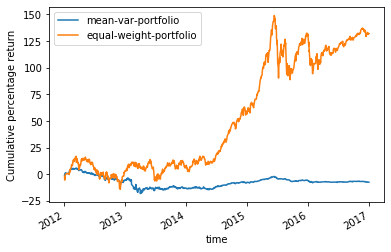

In [454]:
theta_nparray = solvers.meanvariance.mean_variance_long_only_mean_cons_opt(training_ids, mean_nparray, cov_nparray, alpha=0.02)
theta_df = pd.DataFrame(data=theta_nparray, 
                        columns=portfolio['pct_chg'].columns, 
                        index=portfolio['pct_chg'].index)
(theta_df * portfolio['pct_chg'].shift(-1)).sum(axis = 1)[training_ids].cumsum().plot()
portfolio['pct_chg'].mean(axis = 1)[training_ids].cumsum().plot()
plt.legend(['mean-var-portfolio','equal-weight-portfolio'])
plt.ylabel('Cumulative percentage return')
plt.show()

In [461]:
PnL_series = (theta_df * portfolio['pct_chg'].shift(-1)).sum(axis = 1)[training_ids]

In [465]:
np.sqrt(252)*(PnL_series.mean()/PnL_series.std())

-0.25455953591404173

In [468]:
1/3

0.3333333333333333

In [7]:
SZ_code_list

0      000001.SZ
1      000002.SZ
2      000004.SZ
3      000005.SZ
4      000006.SZ
         ...    
774    002324.SZ
775    002325.SZ
776    002326.SZ
777    002327.SZ
778    002328.SZ
Name: ts_code, Length: 775, dtype: object